In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('hh_ru_dataset.csv')

# Обработка пустых значений

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   topic_id                 500000 non-null  object 
 1   topic_creation_date      500000 non-null  object 
 2   initial_state            499166 non-null  object 
 3   final_state              499166 non-null  object 
 4   resume_id                500000 non-null  object 
 5   resume_creation_date     500000 non-null  object 
 6   profession               500000 non-null  object 
 7   gender                   500000 non-null  object 
 8   year_of_birth            500000 non-null  int64  
 9   resume_region            500000 non-null  object 
 10  education_level          499898 non-null  object 
 11  expected_salary          489214 non-null  float64
 12  relocation_status        500000 non-null  object 
 13  business_trip_readiness  500000 non-null  object 
 14  work

Смело удалаяем строки с пустыми initial_state, final_state, education_level. По поводу остальных вопрос. Nan в resume_skills_list - это просто пустой список как я понял; предлагаемая зарплата вакансии отсутствует где-то, но это норм по идее.

In [3]:
"""Остались Nan'ы в столбцах ожидаемой зарплаты, графика, границ предлагаемой зп вакансии. В случае 
гипотезы по этим параметрам не забыть удалить их.
"""
df = df[(~df.initial_state.isna()) & (~df.final_state.isna()) & (~df.education_level.isna())]
# expected_salary пока нет смысла убирать Nan'ы
df['work_schedule'] = df['work_schedule'].fillna('no data')
df.resume_skills_list = df.resume_skills_list.map(lambda x: eval(x) if (x and type(x)) != float else [])
df.vacancy_skills_list = df.vacancy_skills_list.map(lambda x: eval(x) if (x and type(x)) != float else [])
df.topic_creation_date = pd.to_datetime(df.topic_creation_date)
df.resume_creation_date = pd.to_datetime(df.resume_creation_date)
df.vacancy_creation_date = pd.to_datetime(df.vacancy_creation_date)
# как я понял, случай response-response - это когда отклик остался неотвеченным, случай invitation-
# discard непонятный + таких мало, поэтому я убрал его
df = df[(df.initial_state != 'invitation') | (df.final_state != 'discard')]
df['final'] = df['final_state'].map(lambda x: 1 if x == 'invitation' else 0)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 498218 entries, 0 to 499999
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   topic_id                 498218 non-null  object        
 1   topic_creation_date      498218 non-null  datetime64[ns]
 2   initial_state            498218 non-null  object        
 3   final_state              498218 non-null  object        
 4   resume_id                498218 non-null  object        
 5   resume_creation_date     498218 non-null  datetime64[ns]
 6   profession               498218 non-null  object        
 7   gender                   498218 non-null  object        
 8   year_of_birth            498218 non-null  int64         
 9   resume_region            498218 non-null  object        
 10  education_level          498218 non-null  object        
 11  expected_salary          487488 non-null  float64       
 12  relocation_status    

# Выбросы и дубликаты

Есть ~2000 наблюдей с повторяющимся id, но думаю не страшно, мб просто наложилось и т.д.
Не совсем понятно, как работают статусы взаимодействия

In [5]:
df.profession.unique()

array(['Менеджер по продажам, менеджер по работе с клиентами',
       'Дизайнер, художник', 'Программист, разработчик', 'Бухгалтер',
       'Менеджер по маркетингу, интернет-маркетолог',
       'Официант, бармен, бариста', 'Менеджер по персоналу',
       'Менеджер по логистике, менеджер по ВЭД',
       'Оператор ПК, оператор базы данных',
       'Специалист по подбору персонала', 'Менеджер по закупкам',
       'Директор магазина, директор сети магазинов',
       'Делопроизводитель, архивариус', 'Юрисконсульт',
       'Инженер-энергетик, инженер-электрик',
       'Руководитель отдела продаж', 'Специалист технической поддержки',
       'Водитель', 'Учитель, преподаватель, педагог', 'Офис-менеджер',
       'Охранник', 'Воспитатель, няня', 'Сварщик', 'Экономист',
       'Психолог', 'Системный администратор', 'Курьер',
       'Секретарь, помощник руководителя, ассистент',
       'SMM-менеджер, контент-менеджер', 'Тестировщик',
       'Руководитель проектов',
       'Инженер-конструктор, инж

Можно увидеть, что некотороые указывают в анкете несколько специализаций, можно посмотреть как кол-во специализаций влияет на успех в поиске работы. Также думаю, что можно разделить профессии по сферам деятельности.
По поводу возраста, я думаю если его изучать, то лучше отсечь всех пенсионеров(есть выброс по типу год рождения 1900, тут конечно можно любой порог установить, но мне кажется что пенсионный возраст здесь подойдет)
В графе "ожидаемая зарплата" есть выбросы, если ее смотреть то убирать. Есть и в большую сторону(1000000 и больше), и в меньшую(меньше МРОТ, но надо смотреть чтобы это была работа в полный день, иначе это оправдано)
В желаемом графике нет некоторых данных.
В месяцах опыта есть выбросы, по типу 30, 50, 70 лет опыта.
Предлагаемая информация не везде указана.


In [6]:
"""можно попытаться проследить насколько успешна будет заявка, исходя из времени существования резюме; 
кол-ва отправленных заявок и успешных заявок.
Успех заявки можно отслеживать по тому, насколько соискатель соответствовал требованиям вакансии
В профессию в анкете иногда добавляют несколько, можно рассмотреть успех сосискателя по кол-ву 
специализаций в анкете.
"""
(df.resume_creation_date < '2015').sum() # самое первое резюме - в 2002, более 50к пятилетних резюме;

52902

In [7]:
((df.expected_salary < 11000) & (df.vacancy_employment_type == 'full')).sum() # 4371 с зп меньше прожиточного

4368

# Смотрим гипотезу о дате регистрации и кол-ве заявок

Нулевая гипотеза состоит в том, что средний процент успеха не отличается в группах с теми, кто подается первую-третью заявку, и с теми, кто подал уже больше трех заявок.
Альтернативная гипотеза состоит в том, что средний процент успеха в этих группах отличается.

In [8]:
users = df.copy()

In [9]:
users['days']=(users.topic_creation_date-users.resume_creation_date).map(lambda x: x.days)

In [10]:
d = dict()
for i in users.index:
    note = users.loc[i]
    d[note['resume_id']] = d.get(note['resume_id'], []) + [note['topic_creation_date']]

In [11]:
for i, j in d.items():
    d[i]=np.array(j)
def f(resume_id, dt):
    if resume_id not in d.keys():
        return 0
    return sum(d[resume_id] < dt)

In [12]:
users['exp'] = users.apply(lambda x: f(x.resume_id, x.topic_creation_date), 1)

Назовем пользователя опытным, если он сделал уже три заявки. Разделим наблюдения на группы.

In [13]:
old = users[users.exp >= 4].final
new = users[users.exp < 4].final

In [14]:
mean_a = new.mean()
mean_b = old.mean()
sd_a = (new.map(lambda x: (x - mean_a) ** 2).sum() / (len(new) - 1)) ** 0.5
sd_b = (old.map(lambda x: (x - mean_b) ** 2).sum() / (len(old) - 1)) ** 0.5
mean_a, mean_b, sd_a, sd_b

(0.4045983827053374,
 0.26577925509508527,
 0.49081481910831337,
 0.44174895272191095)

In [15]:
se = (sd_a ** 2 / len(new) + sd_b ** 2 / len(old)) ** 0.5
se

0.0014662242262843891

In [16]:
t_cr = (mean_a - mean_b) / se
deg_f = len(old) + len(new) - 2
t_cr, deg_f

(94.67796611302666, 498216)

При данном значении t, p-уровень значимости меньше 0,01. т.е. различия можно назвать статистически значимыми, но тут можно заметить, что процент успеха больше у неопытных пользователей, из этого легко сделать вывод о том, что скорее всего востребованный соискатель найдет работу за один-два отклика, в то время как его коллеги, которые менее квалифицированы или чересчур требоовательны, вынуждены подавать большое количество заявок. Однако такая гипотеза и такой вывод будут слишком тривиальными на мой взгляд.

# Гипотеза о знании англ языка

Допустим, что знание аглийского языка в некоторых сферах более востребовано чем в других.

In [17]:
# проведем анализ профессий и сгруппируем по сфере деятельности
# сразу уберем не интересующие на наблюдения по типу подработок
eng = df.copy()
eng = eng[eng.vacancy_employment_type == 'full']
eng.profession.unique()

array(['Менеджер по продажам, менеджер по работе с клиентами',
       'Дизайнер, художник', 'Программист, разработчик', 'Бухгалтер',
       'Менеджер по маркетингу, интернет-маркетолог',
       'Официант, бармен, бариста', 'Менеджер по персоналу',
       'Менеджер по логистике, менеджер по ВЭД',
       'Оператор ПК, оператор базы данных',
       'Специалист по подбору персонала', 'Менеджер по закупкам',
       'Директор магазина, директор сети магазинов',
       'Делопроизводитель, архивариус', 'Юрисконсульт',
       'Инженер-энергетик, инженер-электрик',
       'Руководитель отдела продаж', 'Специалист технической поддержки',
       'Водитель', 'Учитель, преподаватель, педагог', 'Офис-менеджер',
       'Охранник', 'Воспитатель, няня', 'Сварщик', 'Экономист',
       'Психолог', 'Системный администратор', 'Курьер',
       'Секретарь, помощник руководителя, ассистент',
       'SMM-менеджер, контент-менеджер', 'Тестировщик',
       'Руководитель проектов',
       'Инженер-конструктор, инж

Разделим профессии на следующие категории: менеджмент, дизайн, IT, сфера услуг, правовое поле, инженерия, образование, медицина.

In [18]:
management = ['Менеджер по продажам, менеджер по работе с клиентами', 'Бухгалтер', 'Менеджер по маркетингу, интернет-маркетолог',
             'Менеджер по персоналу', 'Менеджер по логистике, менеджер по ВЭД', 'Специалист по подбору персонала',
             'Менеджер по закупкам', 'Директор магазина, директор сети магазинов', 'Руководитель отдела продаж',
             'Офис-менеджер', 'Секретарь, помощник руководителя, ассистент', 'Руководитель проектов',
             'Финансовый менеджер', 'Администратор', 'Продавец-консультант, продавец-кассир', 
             'Менеджер по туризму', 'Координатор отдела продаж', 'Менеджер ресторана', 'Специалист по кадрам',
             'Менеджер/руководитель АХО']
design = ['Дизайнер, художник', 'Мерчандайзер']
it = ['Программист, разработчик', 'Оператор ПК, оператор базы данных', 'Системный администратор',
     'SMM-менеджер, контент-менеджер', 'Тестировщик', 'Аналитик']
service = ['Официант, бармен, бариста', 'Специалист технической поддержки', 'Водитель', 'Охранник',
          'Курьер', 'Супервайзер', 'Кассир-операционист', 'Диспетчер', 'Торговый представитель', 
          'Упаковщик, комплектовщик', 'Повар, пекарь, кондитер', 'Кладовщик', 
          'Продавец-консультант, продавец-кассир', 'Начальник склада', 'Фитнес-тренер, инструктор тренажерного зала',
          'Товаровед', 'Оператор call-центра, специалист контактного центра', 'Уборщица, уборщик',
          'Разнорабочий']
law = ['Делопроизводитель, архивариус', 'Юрисконсульт', 'Экономист', 'Юрист', 'Кредитный специалист']
engineering = ['Инженер-энергетик, инженер-электрик', 'Сварщик', 'Инженер-конструктор, инженер-проектировщик',
              'Слесарь, сантехник', 'Начальник производства', 'Начальник смены, мастер участка', 
              'Оператор производственной линии', 'Технолог', 'Машинист', 'Механик', 'Сервисный инженер, инженер-механик',
              'Инженер по охране труда и технике безопасности, инженер-эколог']
teacher = ['Учитель, преподаватель, педагог', 'Воспитатель, няня']
med = ['Психолог', 'Врач']

In [19]:
def f(x):
    if x in management:
        return "Менеджмент"
    if x in design:
        return "Дизайн"
    if x in it:
        return "IT"
    if x in service:
        return "Сфера услуг"
    if x in law:
        return "Право/Экономика"
    if x in engineering:
        return "Инженерия/Промышленность"
    if x in teacher:
        return "Образование"
    return "Медицина"
eng = eng[~eng.profession.isna()]
eng['occupation'] = eng.profession.map(f)

In [20]:
eng.occupation.value_counts()

occupation
Менеджмент                  139396
Сфера услуг                 125066
Инженерия/Промышленность     61646
IT                           49000
Право/Экономика              43444
Медицина                      6289
Дизайн                        5283
Образование                   2995
Name: count, dtype: int64

In [21]:
def is_en(skills):
    for i in skills:
        if i and ("английск" in i or "english" in i):
            return True
    return False
eng['en'] = eng.resume_skills_list.map(is_en)
eng['need_en'] = eng.vacancy_skills_list.map(is_en)

In [22]:
eng['en'].mean(), eng['need_en'].mean()

(0.055301198977648174, 0.015429939577806561)

В 5,5% случаев соискатель говорит на английском языке, в 1,5% случаев он требуется.

<Axes: xlabel='occupation'>

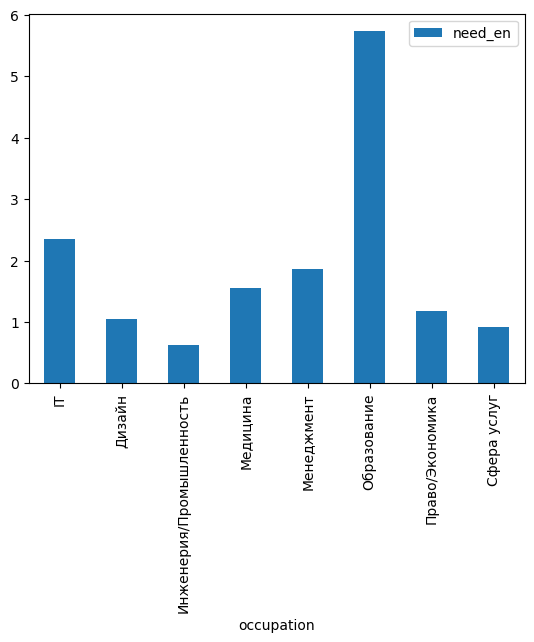

In [23]:
vacancy_inf = eng[['vacancy_id', 'occupation', 'need_en']].drop_duplicates()
(vacancy_inf[['occupation', 'need_en']].groupby('occupation').mean() * 100).plot.bar()

<Axes: xlabel='occupation'>

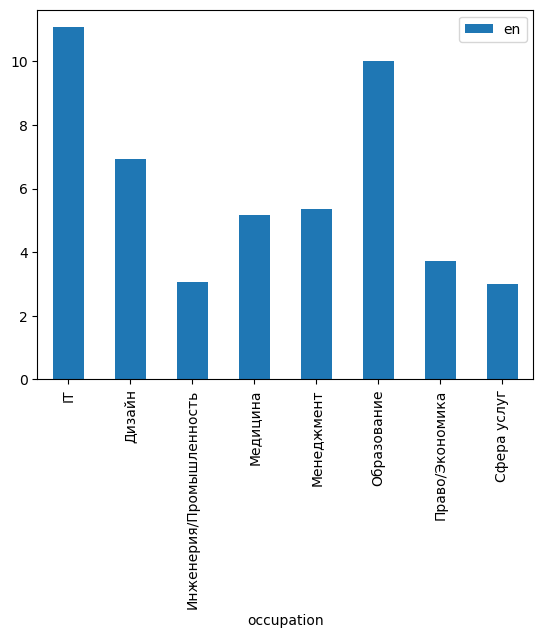

In [24]:
user_inf = eng[['resume_id', 'occupation', 'en']].drop_duplicates()
(user_inf[['occupation', 'en']].groupby('occupation').mean() * 100).plot.bar()

Теперь рассмотрим четыре сценария(NN - соискатель не знает англ и он не требуется, NY - соиск не знает, англ требуется, YN - соиск знает, не требуется, YY - соиск знает и требуется) в срезе каждой из сфер деятельности

In [25]:
eng['scenary'] = eng.apply((lambda x: ('Y' if x['en'] else 'N') + ('Y' if x['need_en'] else 'N')), 1)

In [26]:
gb = eng[['occupation', 'scenary', 'final']].groupby(['occupation', 'scenary']).mean()
gb

final
occupation               scenary          
IT                       NN       0.285837
                         NY       0.188235
                         YN       0.231912
                         YY       0.215434
Дизайн                   NN       0.354223
                         NY       0.228070
                         YN       0.240000
                         YY       0.000000
Инженерия/Промышленность NN       0.329338
                         NY       0.184783
                         YN       0.299376
                         YY       0.268293
Медицина                 NN       0.211054
                         NY       0.067568
                         YN       0.182390
                         YY       0.058824
Менеджмент               NN       0.339456
                         NY       0.227461
                         YN       0.336574
                         YY       0.278116
Образование              NN       0.289383
                         NY       0.202020
                         YN       0.317972
                         YY       0.228571
Право/Экономика          NN       0.208756
                         NY       0.133333
                         YN       0.199642
                         YY       0.150000
Сфера услуг              NN       0.422249
                         NY       0.345280
                         YN       0.374792
                         YY       0.293651

<Axes: xlabel='final', ylabel='occupation'>

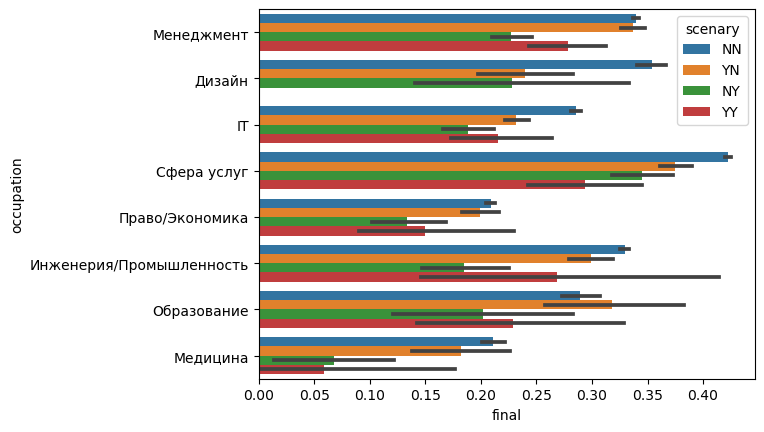

In [27]:
import seaborn as sns
sns.barplot(x='final', y='occupation', hue='scenary', data=eng, orient='h')

Заметим, что в сценариях NN, YN наибольший показатель приема в каждой из сфер. Незначительная разница между YY и NY во многих сферах может быть обусловлена тем, что у соискателя недостаточно высокий уровень английского языка, а также тем, что соискатель может не указывать английский в своих скиллах, но при подаче заявления а вакансию по умолчанию подразумевать то, что английский он знает.

В целом можно сделать предположение о том, что английский язык наиболее востребован в сферах образования, IT и менеджмента, что вполне ожидаемо, так как к последних двух сферах часто приходится работать с иностранцами, а в образовании очень популярна профессия именно учителя английского языка. Также можно предположить, что скорее всего на вакансию, где требуется английский будет сложнее устроиться, даже если вы его знаете. 

# Посмотрим на скиллы чуть подробнее

In [28]:
skills = []
for i in df.resume_skills_list:
    for j in i:
        if j:
            skills.append(j.lower())
skills = pd.Series(skills).value_counts()
list(skills[skills>5000].index)

['ответственность',
 'пользователь пк',
 'работа в команде',
 'организаторские навыки',
 'грамотная речь',
 'деловая переписка',
 'работа с большим объемом информации',
 'деловое общение',
 'обучаемость',
 'исполнительность',
 'работоспособность',
 'ведение переговоров',
 'телефонные переговоры',
 'управление персоналом',
 'коммуникабельность',
 'обучение персонала',
 'заключение договоров',
 'ms excel',
 'стрессоустойчивость',
 'умение работать в команде',
 'деловая коммуникация',
 'обучение и развитие',
 'ms word',
 'активные продажи',
 'английский язык',
 '1с: предприятие 8',
 'ms outlook',
 'навыки продаж',
 'руководство коллективом',
 'ms powerpoint',
 'водительское удостоверение категории b',
 'работа с оргтехникой',
 'поиск информации в интернет',
 'поиск и привлечение клиентов',
 'пунктуальность',
 'подбор персонала',
 'adobe photoshop',
 'управление продажами',
 'делопроизводство',
 'документооборот',
 'прямые продажи',
 'мотивация персонала',
 'документальное сопровождение',


In [29]:
soft_skills = ['ответственность', 'работа в команде', 'организаторские навыки', 'грамотная речь',
 'деловая переписка', 'работа с большим объемом информации', 'деловое общение', 'обучаемость',
 'исполнительность', 'работоспособность', 'ведение переговоров', 'телефонные переговоры',
 'управление персоналом', 'коммуникабельность', 'стрессоустойчивость', 'умение работать в команде',
 'деловая коммуникация', 'обучение и развитие', 'активные продажи', 'руководство коллективом',
 'пунктуальность', 'управление проектами', 'грамотность', 'навыки межличностного общения',
 'креативность', 'управленческие навыки', 'клиентоориентированность', 'умение работать в коллективе',
 'аналитическое мышление', 'управление командой', 'точность и внимательность к деталям',
 'целеустремленность', 'внимательность', 'копирайтинг', 'многозадачность', 'работа с возражениями',
 'навыки переговоров', 'навыки презентации', 'способность обучать других',
 'управление производственным персоналом', 'доброжелательность', 'урегулирование конфликтов',
 'планирование', 'быстрая обучаемость']
extra_skills=['пользователь пк', 'заключение договоров', 'ms excel', 'ms word', 'английский язык',
 'ms outlook', 'ms powerpoint', 'водительское удостоверение категории b', 'работа с оргтехникой',
 'проведение инвентаризаций', 'уверенный пользователь пк', 'договорная работа', 'составление договоров',
 'ведение отчетности', 'ведение групп в социальных сетях', 'работа с документами', 'работа с возражениями',
 'претензионная работа', 'навыки переговоров', 'офисная техника', 'обслуживание покупателей',
 'электронный документооборот', 'социальные сети', 'первичная документация', 'работа с жалобами клиентов',
 'навыки презентации', 'транспортная логистика', 'управление производственным персоналом',
 'оформление документации', 'продвижение в социальных группах', 'бумажный документооборот',]
# доп. скиллы - нельзя отнести ни к soft, ни к hard, но могут дать плюс в целом

In [30]:
def soft_count(l):
    res=0
    for i in l:
        if i and i in soft_skills:
            res+=1
    return res
skills_df = df.copy()
skills_df = skills_df[skills_df.vacancy_employment_type == 'full']

In [31]:
skills_df['soft_count'] = skills_df.resume_skills_list.map(soft_count)
skills_df = skills_df[skills_df.soft_count <= 10]

<Axes: xlabel='soft_count'>

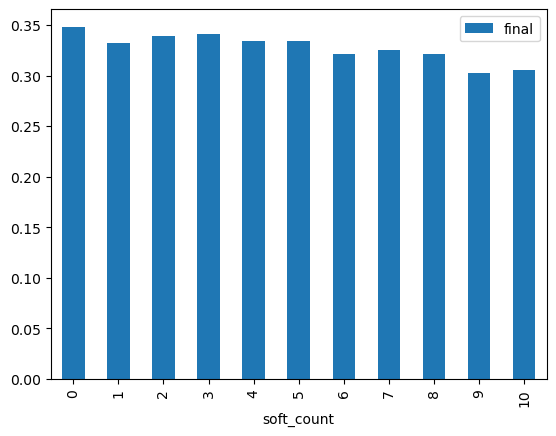

In [32]:
skills_df[['soft_count', 'final']].groupby('soft_count').mean().plot.bar()

In [33]:
# доля софтскиллов от всех
skills_df['soft_part'] = skills_df.soft_count / skills_df.resume_skills_list.map(lambda x: max(1, len(x)))

In [34]:
skills_df['soft_part'] = skills_df.soft_part.map(lambda x: round(x * 50) / 50)

<Axes: xlabel='soft_part'>

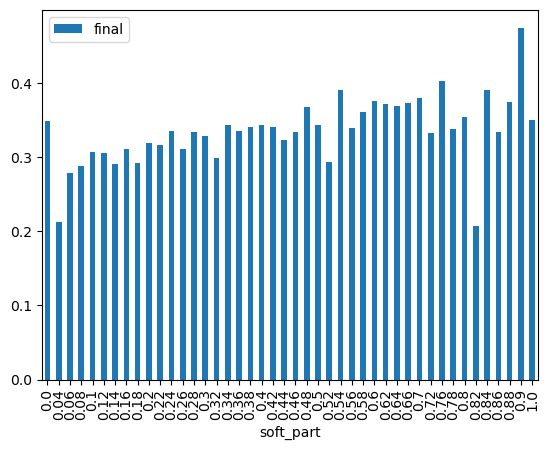

In [35]:
skills_df[['soft_part', 'final']].groupby('soft_part').mean().plot.bar()

# Посмотрим на гипотезу о наилучшем возрасте вхождения

In [36]:
ages = df.copy()
ages['age'] = ages.year_of_birth.apply(lambda x: 2023 - x)

In [37]:
ages.age.value_counts()

age
25     18460
23     17000
26     16799
36     16788
24     16742
       ...  
106        2
85         1
93         1
121        1
103        1
Name: count, Length: 75, dtype: int64

In [38]:
ages = ages[((ages.age <= 58) & (ages.gender == 'female')) 
            | ((ages.age <= 63) & (ages.gender == 'male'))]

In [39]:
ages = ages[~ages.profession.isna()]
ages['occupation'] = ages.profession.map(f)

In [40]:
def f_age(age):
    if age >= 14 and age < 18:
        return "14-17"
    if age >= 18 and age < 23:
        return "18-22"
    if age >= 23 and age < 29:
        return "23-28"
    if age >= 29 and age < 36:
        return "29-35"
    if age >= 36 and age < 46:
        return "36-45"
    if age >= 46 and age < 56:
        return "46-55"
    return "56-63"
ag = ['14-17', '18-22', '23-28', '29-35', '36-45', '46-55', '56-63']
ages['ages_group'] = ages.age.map(f_age)
ages.ages_group.value_counts()

ages_group
36-45    125876
29-35    111761
23-28    101768
46-55     66174
18-22     59141
56-63     15982
14-17     10158
Name: count, dtype: int64

In [41]:
import matplotlib.pyplot as plt

In [42]:
def plot(cat, min_age=14, max_age=63):
    print("Успешность при попытке попасть на собеседование.")
    print(f"Сфера: {cat}")
    curr = ages[(ages.occupation == cat) & (ages.age >= min_age) & (ages.age <= max_age)]
    gb = curr[['age', 'final']].groupby('age').mean()
    # gb.plot.bar()
    sns.barplot(x='age', y='final', hue='gender', data=curr)
def info(cat, min_age, max_age):
    curr = ages[ages.occupation == cat]
    print(f'Отличается ли успех группы {min_age}-{max_age} от среднего?')
    a = curr[(curr.age >= min_age) & (curr.age <= max_age)].final
    b = curr[(curr.age < min_age) | (curr.age > max_age)].final
    mean_a = a.mean()
    mean_b = b.mean()
    print(f"Показатели лучшей группы: {mean_a};\nПоказатели остальных: {mean_b}")
    alpha = mean_a - mean_b
    se = ((a.std() ** 2) / len(a) + (b.std() ** 2) / len(b)) ** 0.5
    print(f"Стандартная ошибка среднего: {se}")
    t = alpha / se
    print(f"t-критерий: {t}")
    print(f"Степени свободы: {len(a) + len(b) - 2}")
    if t < 1.6449:
        print("p-уровень значимость больше 0.1")
        print(f"Между успешностью группы {min_age}-{max_age} и ген. совокупности статистически значимых раличий нет")
    else:
        if t < 1.96:
            print("p-уровень значимость между 0.5 и 0.1")
        elif t < 2.5758:
            print("p-уровень значимость между 0.01 и 0.5")
        else:
            print("p-уровень значимости меньше 0.01")
        print(f"Различия между успешностью группы {min_age}-{max_age} и ген. совокупностью статистически значимые")

Успешность при попытке попасть на собеседование.
Сфера: Менеджмент


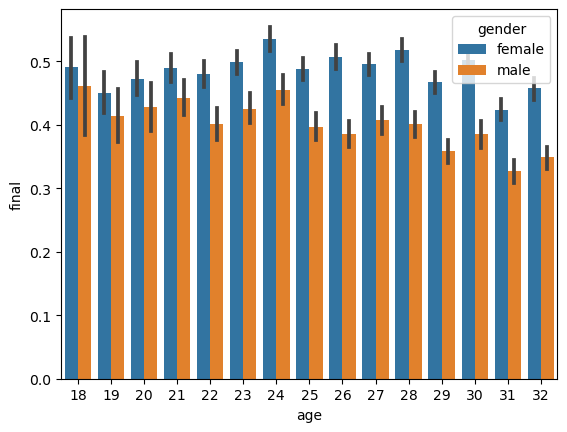

In [43]:
plot('Менеджмент', 18, 32)

In [44]:
info('Менеджмент', 18, 30)

Отличается ли успех группы 18-30 от среднего?
Показатели лучшей группы: 0.45869268292682924;
Показатели остальных: 0.3213278239103659
Стандартная ошибка среднего: 0.002647827571166135
t-критерий: 51.87832490012415
Степени свободы: 151924
p-уровень значимости меньше 0.01
Различия между успешностью группы 18-30 и ген. совокупностью статистически значимые


Вполне ожидаемый результат, ищут молодых и креативных специалистов

Успешность при попытке попасть на собеседование.
Сфера: Сфера услуг


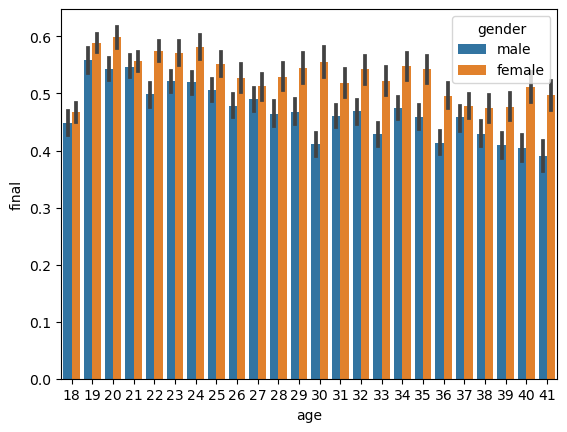

In [45]:
plot('Сфера услуг', 18, 41)

In [46]:
info('Сфера услуг', 19, 40)

Отличается ли успех группы 19-40 от среднего?
Показатели лучшей группы: 0.5068861269734632;
Показатели остальных: 0.3492272650264481
Стандартная ошибка среднего: 0.0026271725467341567
t-критерий: 60.010851644670694
Степени свободы: 148385
p-уровень значимости меньше 0.01
Различия между успешностью группы 19-40 и ген. совокупностью статистически значимые


Поскольку образование для данных специальностей не очень нужно, то ожидаемо, что возраст не будет иметь сильного значение. Единственное ограничение состоит в том, что люди старше 40 не такие быстрые и выносливые для работы в сфере обслуживания или на специальностях, в которых требуется физ.сила.

Успешность при попытке попасть на собеседование.
Сфера: IT


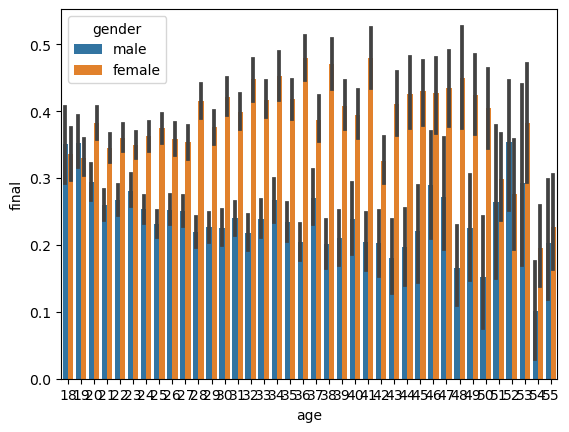

In [47]:
plot('IT', 18, 55)

Очень крутые показатели для группы 40-50. Возможно это обусловлено тем, что молодые специалисты менее квалифицированы(мы видим, что очень мало заявок исходит от людей старше 40, мы можем сделать предположение о том, что это люди, которые очень хорошо разбираются в теме, как минимум потому что люди, которые не умеют работать с компьютером, врятли бы смогли оставить заявку). Молодые же специалисты могут быть выпускниками средних учебных заведений, что нравится далеко не всем работодателям. Можно попытаться рассмотреть данную ситуация в срезе образования и отдельных специальностей. Очень крутые показатели у женского пола возрастов 20-40, при том, что кол-во заявок от мужчин и женщин примерно одинаково. Эту ситуацию также можно рассмотреть поподробнее.

In [48]:
ages[(ages.age > 43) & (ages.occupation == 'IT')]

,topic_id,topic_creation_date,initial_state,final_state,resume_id,resume_creation_date,profession,gender,year_of_birth,resume_region,...,vacancy_region,work_schedule.1,vacancy_employment_type,compensation_from,compensation_to,vacancy_skills_list,final,age,occupation,ages_group
31983,341296412474126c1,2023-06-01,response,response,155015tk1,2021-09-07,"Программист, разработчик",male,1973,Волгоградская область,...,Красноярский край,remote,part,184400.0,243600.0,"[системный анализ, бизнес-анализ, постановка з...",0,50,IT,46-55
31985,33969c69941,2023-08-11,response,invitation,2058240kt,2023-08-11,"Программист, разработчик",male,1976,Красноярский край,...,Красноярский край,remote,part,35000.0,65000.0,"[деловая переписка, работа с большим объемом и...",1,47,IT,46-55
31989,33412747741263,2023-07-02,response,discard,8bk0t814,2018-01-26,"Программист, разработчик",male,1972,Челябинская область,...,Челябинская область,flexible,full,50000.0,NaN,"[svn, ios, intellij idea, git, java, android, ...",0,51,IT,46-55
32037,3341296469647,2023-07-03,response,response,260k64kk,2013-07-21,"Программист, разработчик",male,1971,Краснодарский край,...,Нижегородская область,remote,full,150000.0,NaN,"[1с программирование, знание 1с, 1c: предприят...",0,52,IT,46-55
32046,333044cc996,2023-07-04,response,invitation,260k64kk,2013-07-21,"Программист, разработчик",male,1971,Краснодарский край,...,Нижегородская область,remote,full,160000.0,190000.0,"[1с: предприятие, 1с программирование, удаленн...",1,52,IT,46-55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495472,33763412061412,2023-08-03,response,invitation,18t50k8b,2012-05-15,"Оператор ПК, оператор базы данных",female,1979,Ленинградская область,...,Санкт-Петербург,remote,part,NaN,370000.0,"[консультирование клиентов по телефону, работа...",1,44,IT,36-45
495473,3412933969c97,2023-06-08,invitation,invitation,201850065,2023-06-04,"Оператор ПК, оператор базы данных",female,1970,Санкт-Петербург,...,Санкт-Петербург,full_day,full,30000.0,NaN,"[ведение архива, проектная деятельность, бумаж...",1,53,IT,46-55
495474,33c6c3412670,2023-07-20,response,response,14t16b614,2021-04-23,"Оператор ПК, оператор базы данных",male,1973,Кировская область,...,Санкт-Петербург,remote,full,15000.0,25000.0,"[навыки работы с первичной документацией, комп...",0,50,IT,46-55
495475,b177967606,2023-08-30,response,invitation,18t50k8b,2012-05-15,"Оператор ПК, оператор базы данных",female,1979,Ленинградская область,...,Санкт-Петербург,remote,part,NaN,75000.0,"[удаленная работа, пользователь пк, грамотная ...",1,44,IT,36-45


Успешность при попытке попасть на собеседование.
Сфера: Инженерия/Промышленность


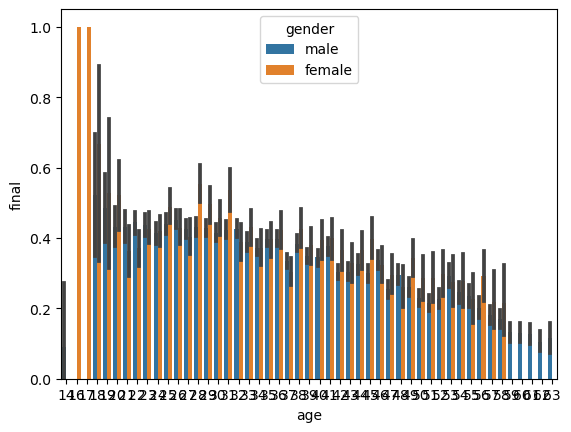

In [49]:
plot('Инженерия/Промышленность')

видим явную склонность к возрасту 20-40. Высокие показатели для несовершеннолетних мб из-за маленького числа заявок.

In [50]:
ages[(ages.occupation=='Инженерия/Промышленность') & (ages.age <= 18)]

,topic_id,topic_creation_date,initial_state,final_state,resume_id,resume_creation_date,profession,gender,year_of_birth,resume_region,...,vacancy_region,work_schedule.1,vacancy_employment_type,compensation_from,compensation_to,vacancy_skills_list,final,age,occupation,ages_group
76854,33cc96c73412c,2023-07-20,invitation,invitation,202l8241,2023-06-16,Сварщик,male,2005,Томская область,...,Томская область,full_day,full,50000.0,50000.0,"[способность обучать других, сварочные работы,...",1,18,Инженерия/Промышленность,18-22
93582,3379397449,2023-08-05,response,response,20l55tf,2023-08-05,Сварщик,male,2009,Тверская область,...,Тверская область,flyInFlyOut,full,115000.0,145000.0,"[сварщик вахта питание и проживание, сварщик в...",0,14,Инженерия/Промышленность,14-17
93583,3379397041,2023-08-05,response,discard,20l55tf,2023-08-05,Сварщик,male,2009,Тверская область,...,Тверская область,shift,full,70000.0,NaN,"[чтение чертежей, владение полуавтоматической ...",0,14,Инженерия/Промышленность,14-17
93584,3379404120c4,2023-08-05,response,response,20l55tf,2023-08-05,Сварщик,male,2009,Тверская область,...,Тверская область,flyInFlyOut,full,140000.0,0.0,[работа в команде],0,14,Инженерия/Промышленность,14-17
93585,33794041210412,2023-08-05,response,response,20l55tf,2023-08-05,Сварщик,male,2009,Тверская область,...,Тверская область,flyInFlyOut,full,112000.0,NaN,[None],0,14,Инженерия/Промышленность,14-17
93595,3379396977,2023-08-05,response,invitation,20l55tf,2023-08-05,Сварщик,male,2009,Тверская область,...,Тверская область,full_day,full,70000.0,NaN,[None],1,14,Инженерия/Промышленность,14-17
93648,339630c96697,2023-08-08,invitation,invitation,2055tk45k,2023-08-07,Сварщик,male,2005,Ростовская область,...,Ростовская область,full_day,full,45000.0,NaN,[None],1,18,Инженерия/Промышленность,18-22
93861,33696496711,2023-07-29,response,invitation,20bk4tt82,2023-07-06,Сварщик,male,2005,Астраханская область,...,Астраханская область,shift,full,30800.0,0.0,"[деловое общение, активные продажи, навыки про...",1,18,Инженерия/Промышленность,18-22
94039,33412c4c96613,2023-06-30,invitation,invitation,20b2b804k,2023-06-28,Сварщик,male,2005,Воронежская область,...,Воронежская область,full_day,full,45000.0,0.0,"[умение работать с клиентами, уверенный пользо...",1,18,Инженерия/Промышленность,18-22
94256,33903669669,2023-08-12,response,discard,1tk2t4525,2023-02-28,Сварщик,male,2005,Московская область,...,Московская область,full_day,full,80000.0,150000.0,"[монтаж оборудования, сварочные работы, монтаж...",0,18,Инженерия/Промышленность,18-22


Успешность при попытке попасть на собеседование.
Сфера: Инженерия/Промышленность


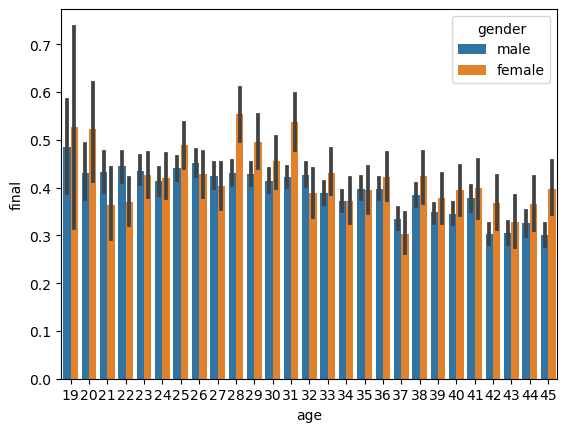

In [51]:
plot('Инженерия/Промышленность', 19, 45)

In [52]:
info('Инженерия/Промышленность', 27, 32)

Отличается ли успех группы 27-32 от среднего?
Показатели лучшей группы: 0.43204553294239395;
Показатели остальных: 0.3314191494200591
Стандартная ошибка среднего: 0.005036099896063795
t-критерий: 19.98101419731253
Степени свободы: 64358
p-уровень значимости меньше 0.01
Различия между успешностью группы 27-32 и ген. совокупностью статистически значимые


Ожидаемые результаты для сферы, где часто требуется физ.сила, а также для опасных и вредных для здоровья профессий.

Успешность при попытке попасть на собеседование.
Сфера: Право/Экономика


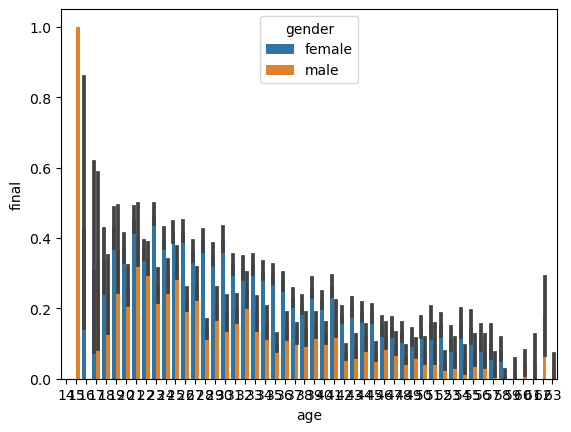

In [53]:
plot('Право/Экономика')

Успешность при попытке попасть на собеседование.
Сфера: Право/Экономика


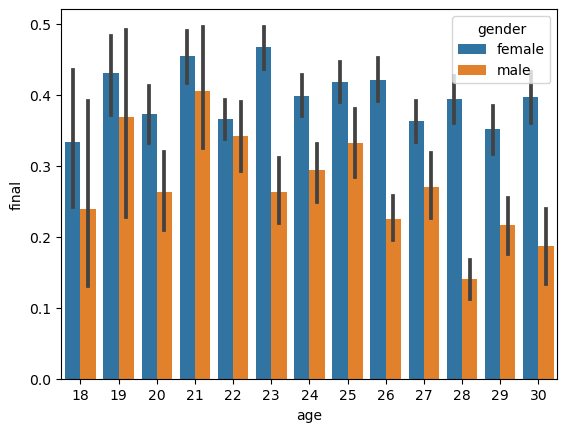

In [54]:
plot('Право/Экономика', 18, 30)

Успешность при попытке попасть на собеседование.
Сфера: Право/Экономика


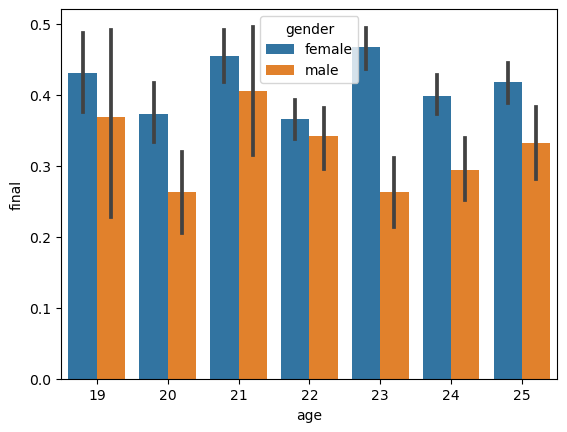

In [55]:
plot('Право/Экономика', 19, 25)

In [56]:
ages[(ages.occupation=='Право/Экономика') & (ages.gender=='male')]

,topic_id,topic_creation_date,initial_state,final_state,resume_id,resume_creation_date,profession,gender,year_of_birth,resume_region,...,vacancy_region,work_schedule.1,vacancy_employment_type,compensation_from,compensation_to,vacancy_skills_list,final,age,occupation,ages_group
46291,33314123969647,2023-07-04,response,response,1645010tb,2022-03-29,"Делопроизводитель, архивариус",male,1960,Москва,...,Москва,full_day,full,65000.0,80000.0,"[adobe acrobat, работа с большим объемом инфор...",0,63,Право/Экономика,56-63
46313,3364796c740,2023-07-26,response,discard,15585185b,2021-09-23,"Делопроизводитель, архивариус",male,1995,Москва,...,Москва,full_day,full,NaN,60000.0,[None],0,28,Право/Экономика,23-28
46316,33077b34120,2023-06-19,response,response,15585185b,2021-09-23,"Делопроизводитель, архивариус",male,1995,Москва,...,Москва,full_day,full,45000.0,70000.0,"[деловая корреспонденция, деловая переписка, т...",0,28,Право/Экономика,23-28
46330,33412c9412741233,2023-06-30,response,invitation,1611tb8b6,2022-01-21,"Делопроизводитель, архивариус",male,1991,Московская область,...,Московская область,full_day,full,25000.0,0.0,"[электронный архив, уверенный пользователь пк,...",1,32,Право/Экономика,29-35
46374,33c190c4c96,2023-07-18,response,response,15585185b,2021-09-23,"Делопроизводитель, архивариус",male,1995,Москва,...,Москва,full_day,full,NaN,60000.0,"[оперативный поиск информации в сети интернет,...",0,28,Право/Экономика,23-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484764,330996719964,2023-06-20,response,response,616b62tk,2017-03-22,Юрисконсульт,male,1974,Оренбургская область,...,Оренбургская область,full_day,full,50000.0,50000.0,"[договорная работа, деловая переписка, согласо...",0,49,Право/Экономика,46-55
484770,330c7412c906,2023-06-17,response,response,2020bb08b,2023-06-07,Юрисконсульт,male,1995,Москва,...,Санкт-Петербург,shift,full,80000.0,100000.0,"[открытие розничных магазинов, активные продаж...",0,28,Право/Экономика,23-28
484771,339643396003,2023-08-08,response,response,4460bg1,2015-08-31,Юрисконсульт,male,1997,Москва,...,Москва,remote,part,40000.0,50000.0,"[юрист, знание законодательства, умение работа...",0,26,Право/Экономика,23-28
484774,330c7396647,2023-06-17,response,response,2020bb08b,2023-06-07,Юрисконсульт,male,1995,Москва,...,Москва,shift,full,80000.0,110000.0,"[работа с кассой, работа в команде, контроль с...",0,28,Право/Экономика,23-28


Слишком большой разброс между женщинами и мужчинами, однако женщин подающих заявки в ~3.5 раза больше, чем мужчин. Также не совсем понятно почему молодых спецов приглашают намного чаще, чем более старших.

Успешность при попытке попасть на собеседование.
Сфера: Дизайн


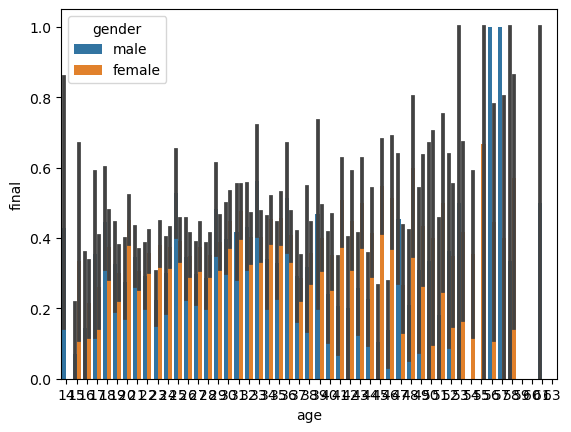

In [57]:
plot('Дизайн')

Поскольку записей о сфере оч мало, то нежелательно по ним выводы делать, а так можно заметить, что в творческих профессиях не очень важен возраст, а также что женщин приглашают на собеседование чаще.

Успешность при попытке попасть на собеседование.
Сфера: Медицина


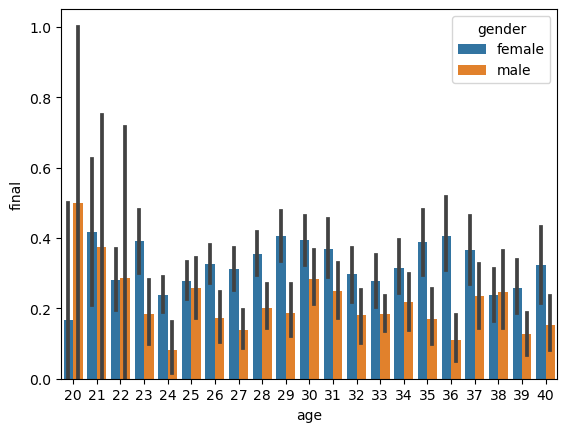

In [58]:
plot('Медицина', 20, 40)

In [59]:
info('Медицина', 25, 34)

Отличается ли успех группы 25-34 от среднего?
Показатели лучшей группы: 0.2794024157660521;
Показатели остальных: 0.21135496183206107
Стандартная ошибка среднего: 0.010187734420757264
t-критерий: 6.679350984586525
Степени свободы: 7336
p-уровень значимости меньше 0.01
Различия между успешностью группы 25-34 и ген. совокупностью статистически значимые


Вполне ожидаемо, наиболее востребованными специалистами являются не очень старые, но опытные специалисты

Успешность при попытке попасть на собеседование.
Сфера: Образование


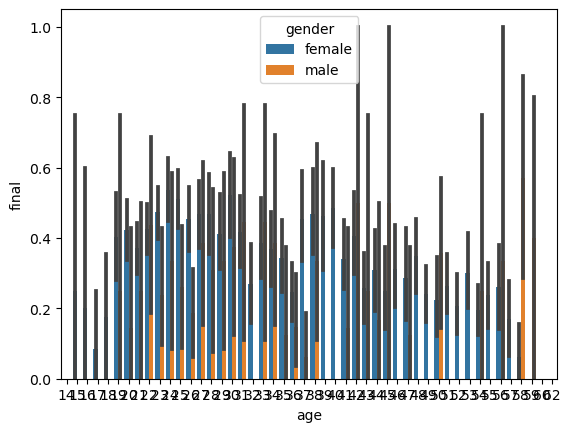

In [60]:
plot('Образование')

Мало инфы, чтобы что-то говорить, на первый взгляд можно сказать, что особых различий нет

In [61]:
ages.occupation.value_counts()

occupation
Менеджмент                  151926
Сфера услуг                 148387
Инженерия/Промышленность     64360
IT                           60753
Право/Экономика              47453
Медицина                      7338
Дизайн                        6847
Образование                   3796
Name: count, dtype: int64

# Смотрим гипотезу о совместимости регионов

In [62]:
regs = df.copy()
regs.resume_region.value_counts()

resume_region
Москва                  148992
Санкт-Петербург          60406
Московская область       33675
Краснодарский край       20169
Республика Татарстан     15344
                         ...  
Еврейская АО                40
Запорожская область         33
Ненецкий АО                  8
Херсонская область           5
Чукотский АО                 4
Name: count, Length: 88, dtype: int64

Идеи две: любо записывать регионы соседи, либо смотреть расстояния между региональными центрами. Пока рассмотрим только случаи совпадения

In [63]:
regs['match'] = regs.apply(lambda x: x['resume_region'] == x['vacancy_region'], 1)

<Axes: xlabel='match'>

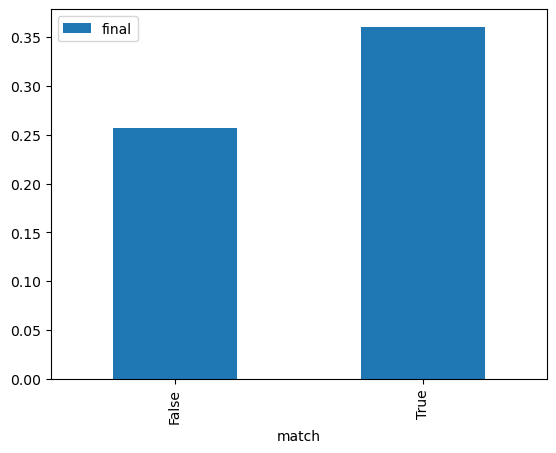

In [64]:
regs_offline = regs[regs['work_schedule.1']!='remote']
offline_inf = regs_offline[['match', 'final']]
offline_inf.groupby('match').mean().plot.bar()

In [65]:
a = offline_inf[offline_inf.match].final
b = offline_inf[~offline_inf.match].final
mean_a = a.mean()
mean_b = b.mean()
alpha = mean_a - mean_b
mean_a, mean_b

(0.36048564998440213, 0.25655045798327714)

In [66]:
se = ((a.std() ** 2) / len(a) + (b.std() ** 2) / len(b)) ** 0.5

In [67]:
t = alpha / se
print(f"t-критерий: {t}; степени свободы: {len(a) + len(b) - 2}")

t-критерий: 49.27890866273391; степени свободы: 409133


<Axes: xlabel='match'>

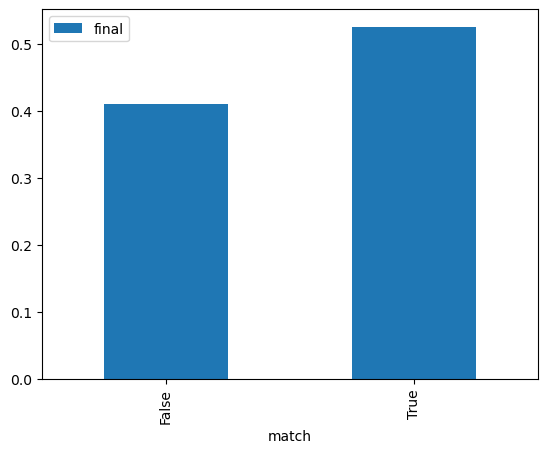

In [68]:
regs_online = regs[regs['work_schedule.1']=='remote']
online_inf = regs_online[['match', 'final']]
online_inf.groupby('match').mean().plot.bar()

In [69]:
a = online_inf[online_inf.match].final
b = online_inf[~online_inf.match].final
mean_a = a.mean()
mean_b = b.mean()
alpha = mean_a - mean_b
mean_a, mean_b

(0.524996904791383, 0.41011951209495257)

In [70]:
se = ((a.std() ** 2) / len(a) + (b.std() ** 2) / len(b)) ** 0.5
se

0.0033381119191522165

In [71]:
t = alpha / se
print(f"t-критерий: {t}; степени свободы: {len(a) + len(b) - 2}")

t-критерий: 34.41388290108796; степени свободы: 89081


Даже на удаленке чаще зовут тех, кто в одном и том же регионе с ними, мб связываться удобнее и все такое

# Смотрим на навыки

In [72]:
skills_df = df[df.resume_skills_list.map(lambda x: x!=[])]

In [73]:
def show_skills(cat, ans_len=20, min_per=2, min_group=0.05):
    print("Смотрим следующие профессии:", *cat)
    curr = skills_df[skills_df.profession.map(lambda x: x in cat)]
    ctr = len(curr)
    print(f"Всего найдено {ctr} наблюдений.")
    curr_skills = dict()
    for i in curr.vacancy_skills_list:
        for j in set(i):
            if j:
                curr_skills[j] = curr_skills.get(j, 0) + 1
    # на данный момент будем обращать внимание только на те скиллы, которые встречаются хотя бы в 2% резюме
    curr_skills_df = pd.DataFrame(data={'Скилл':curr_skills.keys(), 
                                        'Кол-во вакансий':curr_skills.values()})
    curr_skills_df['Процент'] = curr_skills_df['Кол-во вакансий'] / ctr * 100
    curr_skills_df = curr_skills_df[curr_skills_df['Процент'] >= min_per]
    curr_skills_df = curr_skills_df.sort_values(by='Процент', ascending=False)
    curr_skills_df = curr_skills_df.set_index('Скилл')
    print(curr_skills_df)
    print('-'*100)
    # по-хорошему наверное надо 4 сценария смотреть(как в англе), но я не знаю как их оценивать
    res = []
    for i in curr_skills_df.index:
        a = curr[curr.resume_skills_list.map(lambda x: i in x)] # в резюме есть навык
        # тут я подумал, что будет не оч, если размеры оцениваемых групп не больше 10% от всей совокупности
        if len(a) < ctr * min_group:
            continue
        b = curr[curr.resume_skills_list.map(lambda x: i not in x)] # в резюме нет навыка
        if len(b) < ctr * min_group:
            continue
        if len(a) >= len(b):
            a = a.sample(n=len(b))
        else:
            b = b.sample(n=len(a))
        a=a.final
        b=b.final
        se = ((a.std() ** 2) / len(a) + (b.std() ** 2) / len(b)) ** 0.5
        t = (a.mean() - b.mean()) / se
        if t >= 1.967: # df -> inf
            print(f"Для скилла \"{i}\" t-критерий - {t} и степени свободы - {len(a) - 1} и {len(b) - 1}")
            res.append(i)
        elif t < -1.967:
            print(f"!Скилл \"{i}\" негативно влияет на успех. t-критерий - {t} и степени свободы - {len(a) - 1} и {len(b) - 1}")
    print('-'*100)
    print(ans_len, "самых значимых скиллов:", ";\n".join(curr_skills_df.head(ans_len).index))
    return res

In [74]:
it_skills = show_skills(management)
it_skills

Смотрим следующие профессии: Менеджер по продажам, менеджер по работе с клиентами Бухгалтер Менеджер по маркетингу, интернет-маркетолог Менеджер по персоналу Менеджер по логистике, менеджер по ВЭД Специалист по подбору персонала Менеджер по закупкам Директор магазина, директор сети магазинов Руководитель отдела продаж Офис-менеджер Секретарь, помощник руководителя, ассистент Руководитель проектов Финансовый менеджер Администратор Продавец-консультант, продавец-кассир Менеджер по туризму Координатор отдела продаж Менеджер ресторана Специалист по кадрам Менеджер/руководитель АХО
Всего найдено 143540 наблюдений.
                                     Кол-во вакансий    Процент
Скилл                                                          
работа в команде                               24189  16.851749
грамотная речь                                 23575  16.423993
активные продажи                               17097  11.910966
телефонные переговоры                          16357  11.395430

['работа в команде',
 'грамотная речь',
 'активные продажи',
 'телефонные переговоры',
 'пользователь пк',
 'деловое общение',
 'навыки продаж',
 'поиск и привлечение клиентов',
 'прямые продажи',
 'умение работать в команде']

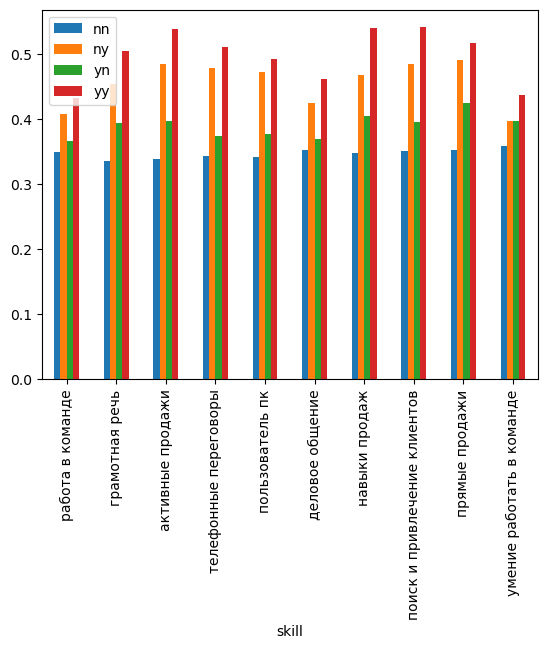

In [75]:
def show_skills_scenaries(cat, skills):
    curr = skills_df[skills_df.profession.map(lambda x: x in cat)]
    nn = [0 for i in skills]
    ny = [0 for i in skills]
    yn = [0 for i in skills]
    yy = [0 for i in skills]
    for i in range(len(skills)):
        temp = skills[i]
        _q = curr.vacancy_skills_list.map(lambda x: temp in x)
        q_ = curr.resume_skills_list.map(lambda x: temp in x)
        nn[i] = curr[(~q_)&(~_q)].final.mean()
        ny[i] = curr[(~q_)&(_q)].final.mean()
        yn[i] = curr[(q_)&(~_q)].final.mean()
        yy[i] = curr[(q_)&(_q)].final.mean()
    res_df = pd.DataFrame(data={'skill':skills, 'nn':nn,'ny':ny,'yn':yn,'yy':yy})
    res_df.plot.bar(x='skill')
show_skills_scenaries(management, it_skills)

In [76]:
def check_skills(cat, skills):
    curr = skills_df.copy()
    curr = curr[curr.profession.map(lambda x: x in cat)]
    skills = set(skills)
    curr['match'] = curr.resume_skills_list.map(lambda x: len(set(x) & skills))
    med = curr.match.median()
    print(f"Медианное число совпадений со скиллами: {med}")
    print(curr.match.value_counts())
    a = curr[curr.match > med].final
    b = curr[curr.match <= med].final
    b = b.sample(n=len(a))
    se = ((a.std() ** 2) / len(a) + (b.std() ** 2) / len(b)) ** 0.5
    t = (a.mean() - b.mean()) / se
    print('-'*100)
    print(f"t-критерий = {t}")

In [77]:
check_skills(it, it_skills)

Медианное число совпадений со скиллами: 0.0
match
0     37819
1      9895
2      5055
3      2935
4      1673
5       623
6       603
7       169
8        89
9        19
10        3
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
t-критерий = 5.813377896914721
